In [1]:
import pandas as pd
from tqdm import tqdm
from database.strategy import Strategy
from database.market import Market
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import numpy as np
import statistics
from sklearn.preprocessing import normalize
from matplotlib import cm
from mpl_toolkits import mplot3d
from strategy.weekly_trade_signal import WeeklyTradeSignal
from strategy.quarterly_financial_categorical import QuarterlyFinancialCategorical
from strategy.daily_price import DailyPrice
from strategy.daily_jump import DailyJump
from strategy.sector_specific import SectorSpecific

In [2]:
market = Market()
market.connect()
sp5 = market.retrieve_data("sp500")
market_prices = market.retrieve_data("prices")
insane = market.retrieve_data("bench")
market.close()

In [3]:
strat = SectorSpecific()
strat_db = strat.db
start = datetime(2013,1,1)
end = datetime(2021,1,1)

In [255]:
strat_db.connect()
tse = strat_db.retrieve_data("epochs")
strat_db.close()

In [256]:
len(tse)

16

In [257]:
bench = pd.read_csv("bench.csv")

In [258]:
bench["Date"] = pd.to_datetime(bench["Date"])
bench["year"] = [x.year for x in bench["Date"]]
bench["month"] = [x.month for x in bench["Date"]]

In [259]:
strat_db.connect()
analysis = []
seats = 3
cash = 100
for epoch in tqdm(tse["epoch"].unique()):
    epoch_dict = tse[tse["epoch"]==epoch].iloc[0]
    trades = strat_db.retrieve_data("trades_{}".format(epoch))
    trades = trades[(trades["date"]>=start) & (trades["sell_date"] <= end)]
    if trades.index.size < 1:
        print(epoch,trades.index.size)
        continue
    else:
        index = 0
        captured_seats = 0
        while captured_seats < seats or index < seats:
            initial = float(cash/(seats))
            seat_trades = trades[trades["seat"] == index]
            seat_trades.sort_values("sell_date",inplace=True)
            if index > 20:
                break
            if captured_seats > seats:
                break
            if seat_trades.index.size > 0:
                for delta in seat_trades["sell_delta"]:
                    initial = initial * (1 + delta)
                stg = seat_trades.groupby("seat").mean().reset_index()[["adjclose","sell_price","seat","sell_delta"]]
                for col in list(tse.columns):
                    if col == "__id":
                        continue
                    else:
                        stg[col] = epoch_dict[col]
                stg["initial_pv"] = initial
                stg["trades"] = seat_trades.index.size
                stg["seat"] = captured_seats
                stg["hpr"] = seat_trades["hpr"].mean()
                stg["winrate"] = seat_trades[seat_trades["sell_delta"] > 0].index.size / seat_trades.index.size
                initial = float(cash/(seats + 1))
                analysis.append(stg)
                index += 1
                captured_seats += 1
                continue
            else:
                index += 1
                continue
strat_db.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 34.18it/s]


In [260]:
a = pd.concat(analysis)

In [261]:
a.sort_values("initial_pv",ascending=False)

,adjclose,sell_price,seat,sell_delta,_id,epoch,score,d,initial_pv,trades,hpr,winrate
0,62.523939,63.044945,0,0.007604,61027a9ca050601b146b670e,15,0.81,0.09,467.492655,416,2.853365,0.543269
0,55.285195,55.761588,0,0.007158,61027ae2a050601b146b6bee,16,0.86,0.09,403.753222,416,2.846154,0.545673
0,42.435653,42.712759,0,0.006098,61027b28a050601b146b70cd,17,0.91,0.09,255.973822,416,2.838942,0.516827
0,62.523939,63.014303,0,0.005815,61027997a050601b146b5495,10,0.81,0.06,240.661319,416,2.793269,0.543269
0,55.285195,55.746985,0,0.005718,610279dca050601b146b5975,11,0.86,0.06,236.214153,416,2.798077,0.545673
0,59.317521,59.907222,1,0.004977,61027ae2a050601b146b6bee,16,0.86,0.09,174.552669,415,2.857831,0.554217
0,55.285195,55.655390,0,0.004505,610278d6a050601b146b46fc,6,0.86,0.03,151.999003,416,2.632212,0.552885
0,59.317521,59.887021,1,0.004498,610279dca050601b146b5975,11,0.86,0.06,145.932344,415,2.831325,0.554217
0,42.435653,42.684737,0,0.004412,61027a20a050601b146b5e54,12,0.91,0.06,136.349547,416,2.798077,0.516827
0,62.523939,62.831979,0,0.003861,61027891a050601b146b421c,5,0.81,0.03,115.080441,416,2.632212,0.545673


In [262]:
metric = "initial_pv"
index_cols = list(tse.columns)
index_cols.remove("_id")
tsmc = ""
apt = a.pivot_table(index=index_cols,columns="seat",values=metric)
if metric == "winrate" or metric == "hpr":
    apt[metric] = [statistics.mean([row[1][i] for i in range(seats) if not np.isnan(row[1][i])]) for row in apt.iterrows()]
else:
    apt.fillna(cash/(seats+1),inplace=True)
    apt[metric] = [sum([row[1][i] for i in range(seats+1) if i in apt.columns]) for row in apt.iterrows()]
    apt["perf"] = 1 + (apt[metric] - cash) / cash
apt.reset_index(inplace=True)

In [263]:
apt.sort_values(metric,ascending=False).head(10)

seat,epoch,score,d,0,1,2,initial_pv,perf
13,16,0.86,0.09,403.753222,174.552669,53.525152,631.831043,6.318310
12,15,0.81,0.09,467.492655,112.952173,43.695769,624.140598,6.241406
9,11,0.86,0.06,236.214153,145.932344,52.372858,434.519354,4.345194
14,17,0.91,0.09,255.973822,70.143216,78.000567,404.117605,4.041176
8,10,0.81,0.06,240.661319,94.457676,39.230477,374.349471,3.743495
10,12,0.91,0.06,136.349547,67.815751,75.997419,280.162717,2.801627
15,18,0.96,0.09,98.658264,64.619223,95.180828,258.458315,2.584583
5,6,0.86,0.03,151.999003,67.358801,31.606905,250.964709,2.509647
11,13,0.96,0.06,71.238640,56.636765,92.478662,220.354066,2.203541
4,5,0.81,0.03,115.080441,63.973759,29.872883,208.927084,2.089271


In [264]:
if tsmc == "industry":
    bf = []
    for industry in apt["industry"].unique():
        industry_apt = apt[apt["industry"] == industry].sort_values(metric,ascending=False).head(1)
        bf.append(industry_apt)
    bff = pd.concat(bf)
    bff.sort_values(metric,ascending=False)

In [265]:
strat_db.connect()
epoch = apt.sort_values(metric,ascending=False).reset_index().iloc[0]["epoch"]
analysis = []
trades = strat_db.retrieve_data("trades_{}".format(int(epoch)))
trades = trades[(trades["date"]>=start) & (trades["sell_date"] <= end)]
strat_db.close()

In [266]:
tse

,_id,epoch,score,d
0,6102778aa050601b146b2fa3,0,0.81,0.00
1,610277cfa050601b146b3483,1,0.86,0.00
2,61027813a050601b146b3962,2,0.91,0.00
3,61027849a050601b146b3e40,3,0.96,0.00
4,61027891a050601b146b421c,5,0.81,0.03
5,610278d6a050601b146b46fc,6,0.86,0.03
6,6102791aa050601b146b4bdb,7,0.91,0.03
7,6102794fa050601b146b50b9,8,0.96,0.03
8,61027997a050601b146b5495,10,0.81,0.06
9,610279dca050601b146b5975,11,0.86,0.06


In [267]:
print("trades:",len(trades))
top_epoch = tse[tse["epoch"]==epoch]
for col in top_epoch.columns:
    print(col,":",top_epoch[col].item())

trades: 1246
_id : 61027ae2a050601b146b6bee
epoch : 16
score : 0.86
d : 0.09


In [268]:
trades.sort_values("date")
trades["date"] = pd.to_datetime(trades["date"])
trades["sell_date"] = pd.to_datetime(trades["sell_date"])
dta = "date"
trades["week"] = [x.week for x in trades[dta]]
trades["quarter"] = [x.quarter for x in trades[dta]]
trades["dayofWeek"] = [x.weekday() for x in trades[dta]]
trades["month"] = [x.month for x in trades[dta]]
trades["year"] = [x.year for x in trades[dta]]
trades = trades[trades["sell_date"] <= end]

In [269]:
prices = trades
daily = prices.groupby(["year","dayofWeek"]).mean().reset_index()
quarterly = prices.groupby(["year","quarter"]).mean().reset_index()
monthly = prices.groupby(["year","month"]).mean().reset_index()
weekly = prices.groupby(["year","week"]).mean().reset_index()

In [270]:
timelines= []
cs = 0
index = 0
index = 0
while cs <= seats or index <= 20:
    timeline = []
    initial = float(cash/(seats + 1))
    st = prices[prices["seat"] == index]
    st.sort_values("date",inplace=True)
    if index > 20:
        break
    if cs > seats:
        break
    if st.index.size > 0:
        for row in tqdm(st.iterrows()):
            trade_chunk = []
            shares = initial / row[1]["adjclose"] 
            ticker = row[1]["ticker"]
            initial = initial * (1+row[1]["sell_delta"])
            for i in range(int((row[1]["sell_date"] - row[1]["date"]).days)+1):
                current_date = row[1]["date"] + timedelta(days=i) 
                timelines.append({"seat":cs,"ticker":ticker,"date":current_date,"shares":shares})
        initial = float(100/(seats + 1))
        index+=1
        cs+=1
        continue
    else:
        index += 1
        continue
ts = pd.DataFrame(timelines)

416it [00:00, 6116.29it/s]
415it [00:00, 6101.63it/s]
415it [00:00, 6192.67it/s]


In [271]:
product = ts.merge(market_prices[["date","ticker","adjclose"]],on=["date","ticker"])
product["pv"] = product["adjclose"] * product["shares"]
ts = product.copy()

In [272]:
tspivot = ts.pivot_table(index="date",columns="seat",values="pv")
tspivot.iloc[0].fillna(100/(seats+1),inplace=True)

In [273]:
cleaned = []
for i in range(tspivot.index.size):
    row = tspivot.iloc[i]
    for col in tspivot.columns:
        if col == "date":
            continue
        else:
            col_val = row[col].item()
            if math.isnan(col_val):
                row[col] = tspivot.iloc[i-1][col].item()
            else:
                continue
    cleaned.append(row)

In [274]:
tspivot = pd.DataFrame(cleaned)

In [275]:
for i in range(seats+1):
    if i not in tspivot.columns:
        tspivot[i] = 100/(seats +1)

In [276]:
# tspivot = ts.pivot_table(index="date",columns="seat",values="pv")
tspivot["pv"] = [sum([row[1][i] for i in range(seats+1) if i in tspivot.columns]) for row in tspivot.iterrows()]
tspivot.reset_index(inplace=True)

In [277]:
pvs = [100]
current_pv = 100
for i in range(1,tspivot.index.size):
    replacement = current_pv/seats
    current_date = tspivot.iloc[i].fillna(replacement)
    current_pv =sum([current_date[c] for c in range(seats+1) if c in tspivot.columns])
    pvs.append(current_pv)
tspivot["pv"] = pvs 

In [278]:
tspivot["pv"] = (tspivot["pv"] - 100) / 100

In [279]:
tspivot["year"] = [x.year for x in tspivot["index"]]
tspivot["month"] = [x.month for x in tspivot["index"]]

In [280]:
tspivot = tspivot.merge(bench,on=["year","month"],how="left")

In [281]:
tspivot

,index,0,1,2,3,pv,year,month,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2013-01-07,25.000000,25.000000,25.000000,25.0,0.000000,2013,1,2013-01-01,"1,426.19","1,509.94","1,426.19","1,498.11","1,498.11","75,848,510,000"
1,2013-01-08,24.318577,24.875156,24.717007,25.0,-0.010893,2013,1,2013-01-01,"1,426.19","1,509.94","1,426.19","1,498.11","1,498.11","75,848,510,000"
2,2013-01-09,24.516375,24.594257,24.225941,25.0,-0.016634,2013,1,2013-01-01,"1,426.19","1,509.94","1,426.19","1,498.11","1,498.11","75,848,510,000"
3,2013-01-10,26.896645,24.687890,23.829310,25.0,0.004138,2013,1,2013-01-01,"1,426.19","1,509.94","1,426.19","1,498.11","1,498.11","75,848,510,000"
4,2013-01-14,26.896645,24.687890,23.829310,25.0,0.004138,2013,1,2013-01-01,"1,426.19","1,509.94","1,426.19","1,498.11","1,498.11","75,848,510,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,2020-12-17,299.081837,132.409479,39.323245,25.0,3.958146,2020,12,2020-12-01,"3,645.87","3,760.20","3,633.40","3,756.07","3,756.07","96,056,410,000"
1598,2020-12-21,299.081837,132.409479,39.323245,25.0,3.958146,2020,12,2020-12-01,"3,645.87","3,760.20","3,633.40","3,756.07","3,756.07","96,056,410,000"
1599,2020-12-22,302.641491,131.407175,39.612980,25.0,3.986616,2020,12,2020-12-01,"3,645.87","3,760.20","3,633.40","3,756.07","3,756.07","96,056,410,000"
1600,2020-12-23,303.366494,131.496428,40.097114,25.0,3.999600,2020,12,2020-12-01,"3,645.87","3,760.20","3,633.40","3,756.07","3,756.07","96,056,410,000"


In [282]:
starting_bench = float(tspivot["Adj Close**"].iloc[0].replace(",",""))
tspivot["bench_pv"] = [(float(x.replace(",","")) - starting_bench)/starting_bench for x in tspivot["Adj Close**"]]

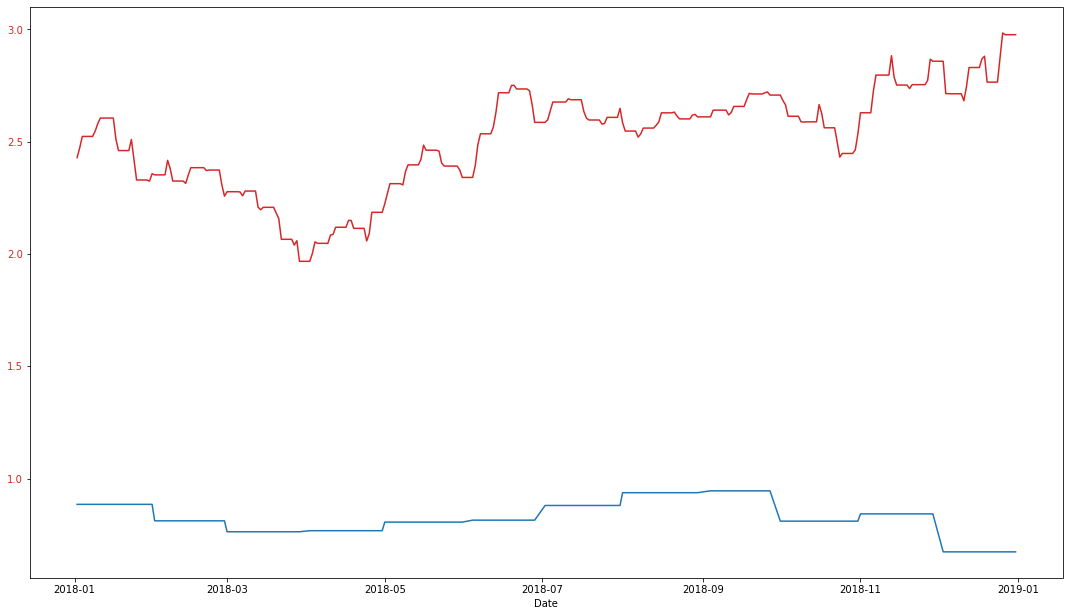

In [283]:
fig, ax1 = plt.subplots()
start_date = datetime(2018,1,1)
end_date = datetime(2019,1,1)
filtered = tspivot[(tspivot["index"] > start_date) & (tspivot["index"] < end_date)]
# filtered_bench = bench[(bench["index"] > start_date) & (bench["index"] < end_date)]
# filtered = tspivot
# filtered_bench = bench
color = 'tab:red'
ax1.set_xlabel('Date')
# ax1.set_ylabel('price', color=color)
ax1.plot(filtered["index"], filtered["pv"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('bench', color=color)  # we already handled the x-label with ax1
ax1.plot(filtered["index"],filtered["bench_pv"], color=color)
# ax2.tick_params(axis='y', labelcolor=color)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

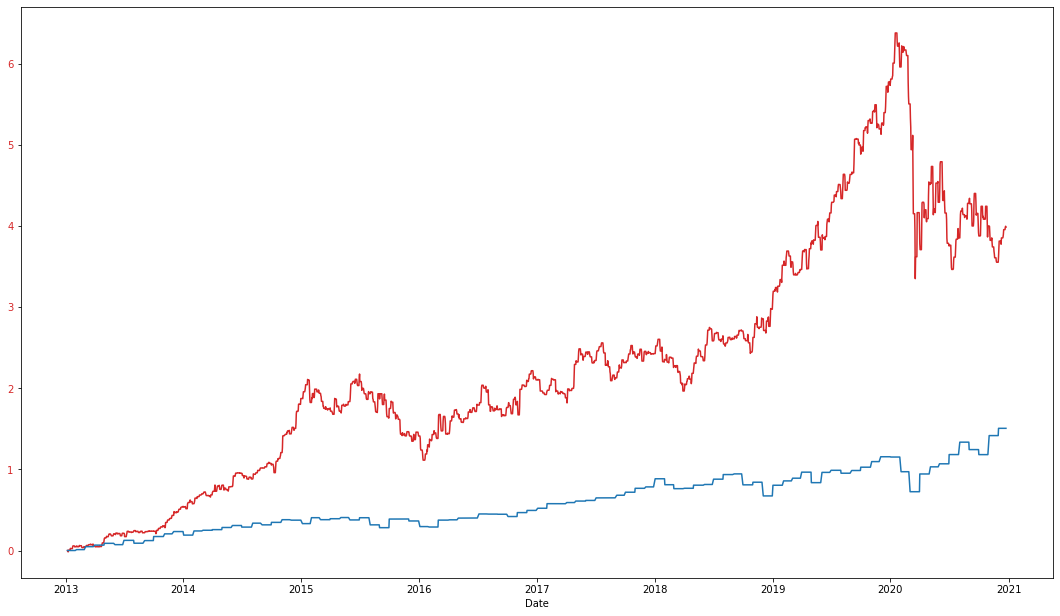

In [284]:
fig, ax1 = plt.subplots()
start_date = start
end_date = end
# filtered = tspivot[(tspivot["index"] > start_date) & (tspivot["index"] < end_date)]
# filtered_bench = bench[(bench["index"] > start_date) & (bench["index"] < end_date)]
filtered = tspivot
# filtered_bench = bench
color = 'tab:red'
ax1.set_xlabel('Date')
# ax1.set_ylabel('price', color=color)
ax1.plot(filtered["index"], filtered["pv"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('bench', color=color)  # we already handled the x-label with ax1
ax1.plot(filtered["index"],filtered["bench_pv"], color=color)
# ax2.tick_params(axis='y', labelcolor=color)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

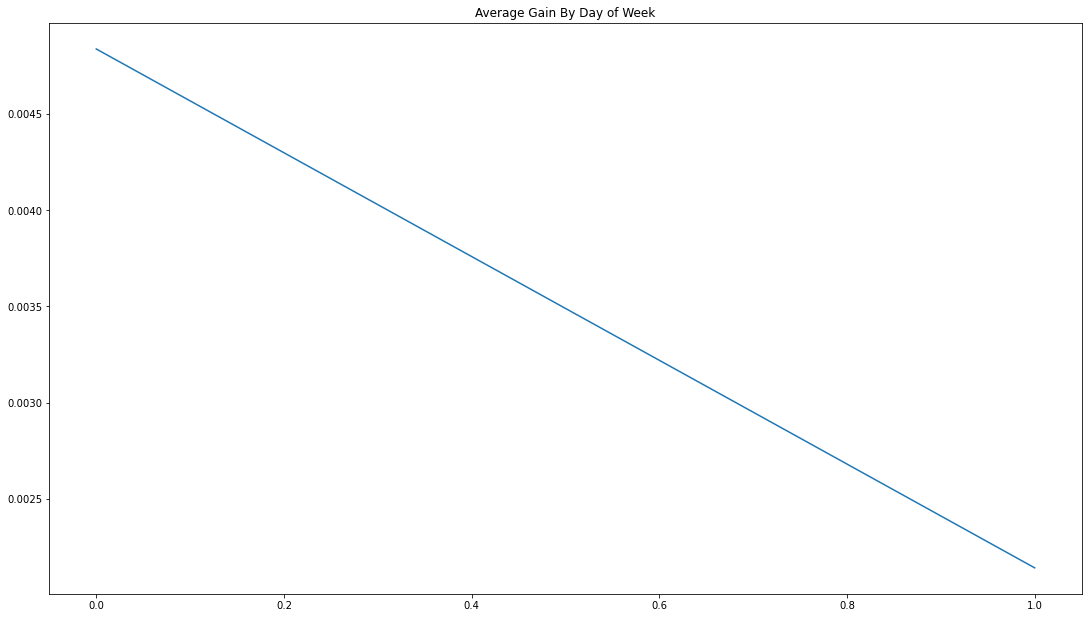

In [285]:
normalized = []
for year in daily["year"].unique():
    try:
        subset = daily[daily["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = daily.groupby("dayofWeek").mean().reset_index()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(grouped["sell_delta"])
plt.title("Average Gain By Day of Week")
plt.show()

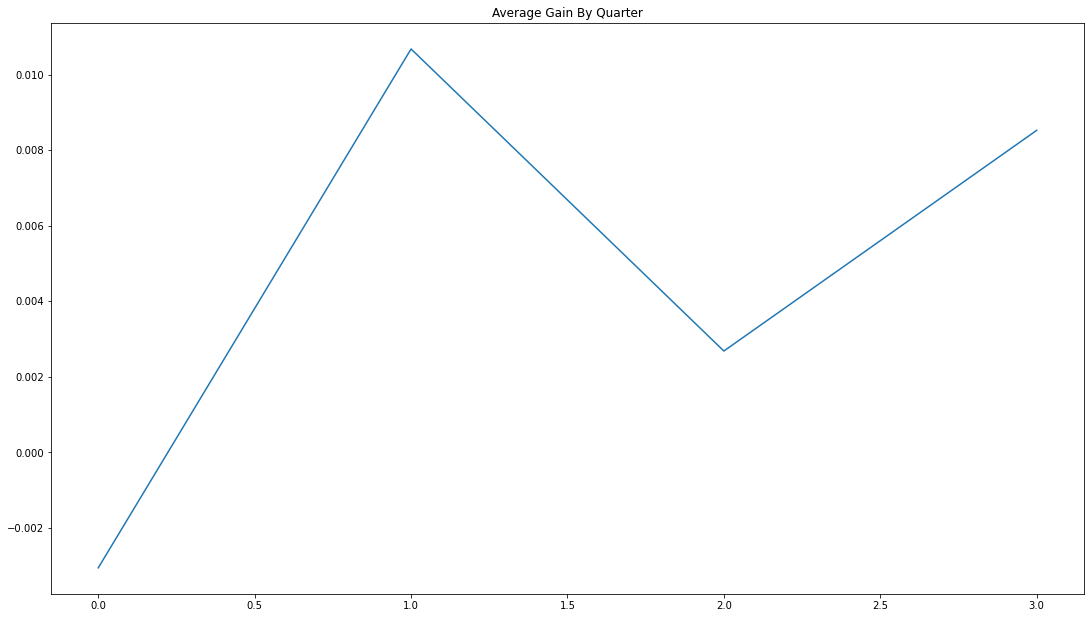

In [286]:
normalized = []
for year in quarterly["year"].unique():
    try:
        subset = quarterly[quarterly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = quarterly.groupby("quarter").mean().reset_index()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(grouped["sell_delta"])
plt.title("Average Gain By Quarter")
plt.show()

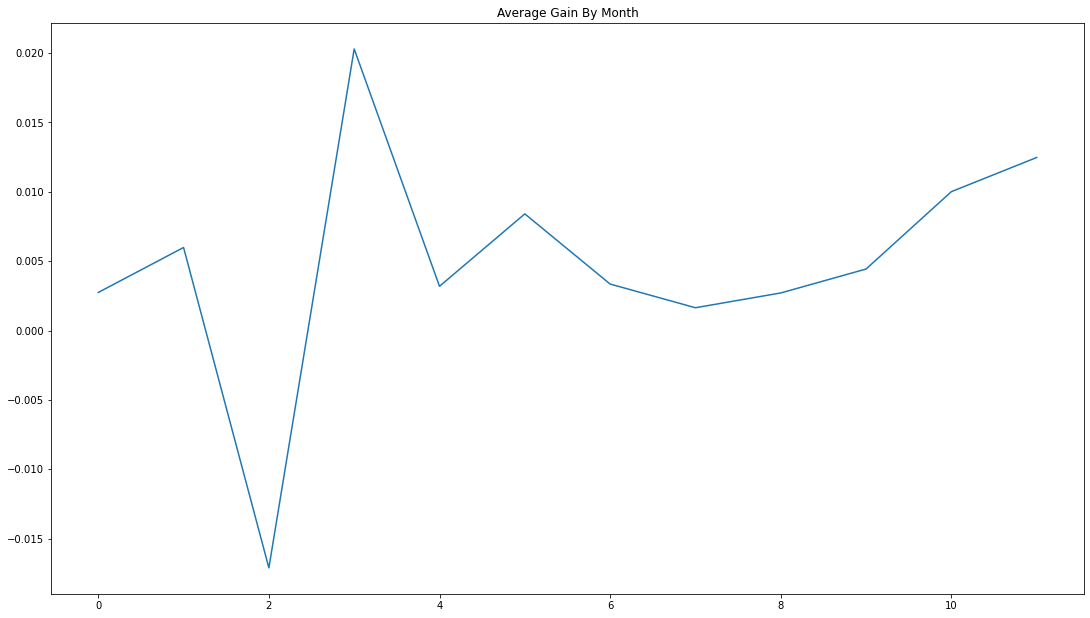

In [287]:
normalized = []
for year in monthly["year"].unique():
    try:
        subset = monthly[monthly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
grouped = monthly.groupby("month").mean().reset_index()
plt.plot(grouped["sell_delta"])
plt.title("Average Gain By Month")
plt.show()

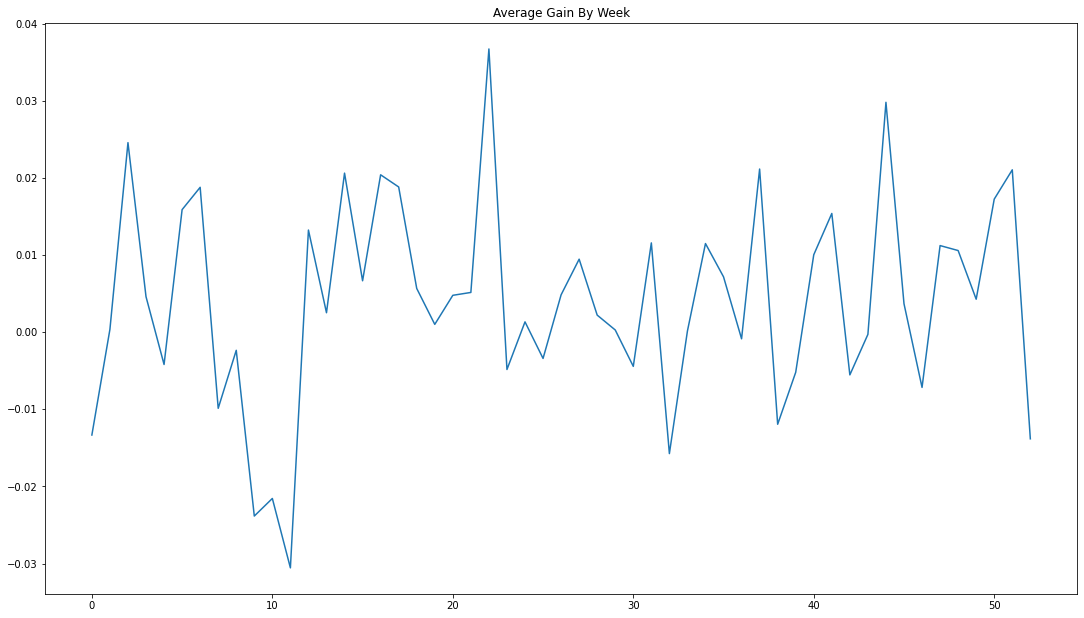

In [288]:
# normalized = []
# for year in weekly["year"].unique():
#     try:
#         subset = weekly[weekly["year"] == year]
#         subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
#         normalized.append(subset)
#     except:
#         continue
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
grouped = weekly.groupby("week").mean().reset_index()
plt.plot(grouped["sell_delta"])
plt.title("Average Gain By Week")
plt.show()

In [289]:
ntrades = []
trades.sort_values("date",inplace=True)
for year in trades["year"].unique():
    subset = trades[(trades["year"] == year)]
    for week in subset["week"].unique():
        ntrades.append(len(subset[(subset["week"] == week)]))
weekly["ntrades"]= ntrades

In [290]:
sp5.columns

Index(['_id', 'Symbol', 'Security', 'SEC filings', 'GICS Sector',
       'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK',
       'Founded', 'ticker'],
      dtype='object')

In [291]:
trades["trade"] = 1

In [292]:
sp5["ticker"] = sp5["Symbol"]

In [293]:
ticker_yearly = trades.groupby(["year","ticker"]).sum().reset_index().merge(sp5, on="ticker",how="left")
yp = []
for year in ticker_yearly["year"].unique():
    yp.append(ticker_yearly[ticker_yearly["year"] == year].sort_values("sell_delta",ascending=False))
yp_final = pd.concat(yp)
yp_final["aggregate_gain"] = [(1+(row[1]["sell_delta"] / row[1]["trade"])) ** row[1]["trade"] - 1 for row in yp_final.iterrows()]
yp_final.sort_values("aggregate_gain",ascending=False)[["year","Security","ticker","GICS Sector","sell_delta","trade","aggregate_gain","hpr"]].head(50)

,year,Security,ticker,GICS Sector,sell_delta,trade,aggregate_gain,hpr
76,2014,Paycom,PAYC,Information Technology,0.283323,10,0.322314,27
3,2013,Advanced Micro Devices,AMD,Information Technology,0.258152,17,0.292026,48
73,2014,ServiceNow,NOW,Information Technology,0.253483,6,0.281812,18
221,2019,Etsy,ETSY,Consumer Discretionary,0.238527,10,0.265828,29
282,2020,Norwegian Cruise Line Holdings,NCLH,Consumer Discretionary,0.233302,7,0.257968,20
127,2016,Howmet Aerospace,HWM,Industrials,0.228037,3,0.245810,8
60,2014,Howmet Aerospace,HWM,Industrials,0.210873,3,0.226043,7
117,2016,CF Industries Holdings Inc,CF,Materials,0.197473,26,0.217412,74
115,2016,Alexion Pharmaceuticals,ALXN,Health Care,0.168364,4,0.179296,11
271,2020,Ford Motor Company,F,Consumer Discretionary,0.178874,1,0.178874,1


In [294]:
trades = trades.merge(sp5, on="ticker",how="left")
ticker_analysis = trades.groupby("ticker").sum().reset_index().merge(sp5, on="ticker",how="left")
ticker_analysis["aggregate_gain"] = [(1+(row[1]["sell_delta"] / row[1]["trade"])) ** row[1]["trade"] - 1 for row in ticker_analysis.iterrows()]
ticker_analysis["average_gain"] = [(row[1]["sell_delta"] / row[1]["trade"]) for row in ticker_analysis.iterrows()]
ticker_analysis.sort_values("aggregate_gain",ascending=False)[["Security","ticker","sell_delta","trade","average_gain"]].head(50)

,Security,ticker,sell_delta,trade,average_gain
85,Howmet Aerospace,HWM,0.446590,17,0.026270
10,Advanced Micro Devices,AMD,0.317133,25,0.012685
131,ServiceNow,NOW,0.303660,8,0.037957
87,Incyte,INCY,0.281609,21,0.013410
141,Paycom,PAYC,0.283323,10,0.028332
34,CF Industries Holdings Inc,CF,0.255257,27,0.009454
58,Devon Energy,DVN,0.245057,8,0.030632
60,DexCom,DXCM,0.241183,18,0.013399
125,Norwegian Cruise Line Holdings,NCLH,0.233302,7,0.033329
184,Vertex Pharmaceuticals Inc,VRTX,0.204514,12,0.017043


In [295]:
ticker_analysis = trades.groupby("GICS Sector").sum().reset_index()
ticker_analysis["aggregate_gain"] = [(1+(row[1]["sell_delta"] / row[1]["trade"])) ** row[1]["trade"] - 1 for row in ticker_analysis.iterrows()]
ticker_analysis["average_gain"] = [(row[1]["sell_delta"] / row[1]["trade"]) for row in ticker_analysis.iterrows()]
ticker_analysis.sort_values("sell_delta",ascending=False)[["GICS Sector","sell_delta","trade","average_gain"]].head(50)

,GICS Sector,sell_delta,trade,average_gain
7,Information Technology,2.401401,206,0.011657
1,Consumer Discretionary,1.606954,319,0.005037
5,Health Care,1.044889,239,0.004372
6,Industrials,0.993047,89,0.011158
2,Consumer Staples,0.210623,23,0.009158
9,Real Estate,0.102308,21,0.004872
8,Materials,0.052110,90,0.000579
4,Financials,-0.043653,30,-0.001455
0,Communication Services,-0.085288,51,-0.001672
3,Energy,-0.200512,158,-0.001269


In [296]:
trades.columns

Index(['_id_x', 'date', 'ticker', 'year', 'quarter', 'week',
       'weekly_price_categorical_regression_prediction',
       'weekly_price_categorical_regression_score',
       'weekly_price_categorical_classification_prediction',
       'weekly_price_categorical_classification_score', 'adjclose',
       'weekly_predicted_delta', 'weekly_predicted_delta_abs', 'sell_price',
       'sell_date', 'sell_delta', 'hpr', 'seat', 'dayofWeek', 'month', 'trade',
       '_id_y', 'Symbol', 'Security', 'SEC filings', 'GICS Sector',
       'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK',
       'Founded'],
      dtype='object')

In [297]:
trades["sell_delta"] = [round(x,2) for x in trades["sell_delta"]]
trades.sort_values("hpr",ascending=False)[["date","seat","sell_date","ticker","adjclose","weekly_price_categorical_regression_prediction","sell_delta","hpr"]].head(50)

,date,seat,sell_date,ticker,adjclose,weekly_price_categorical_regression_prediction,sell_delta,hpr
0,2013-01-07,0,2013-01-10,BBY,10.232980,15.103114,0.08,3
911,2018-10-29,1,2018-11-01,XRAY,34.084386,41.577651,0.02,3
813,2018-03-19,2,2018-03-22,DISH,39.315167,60.074787,-0.05,3
812,2018-03-12,2,2018-03-15,DISH,41.175599,60.074787,-0.02,3
811,2018-03-12,0,2018-03-15,GE,14.023958,26.065297,-0.04,3
810,2018-03-12,1,2018-03-15,NWL,26.139206,39.111579,-0.00,3
809,2018-03-05,0,2018-03-08,GE,13.667898,26.065297,0.01,3
808,2018-03-05,1,2018-03-08,NWL,25.387009,39.111579,-0.02,3
807,2018-03-05,2,2018-03-08,DISH,41.318634,60.074787,-0.00,3
806,2018-02-26,2,2018-03-01,KIM,13.535660,18.779288,-0.00,3


<Figure size 432x288 with 0 Axes>

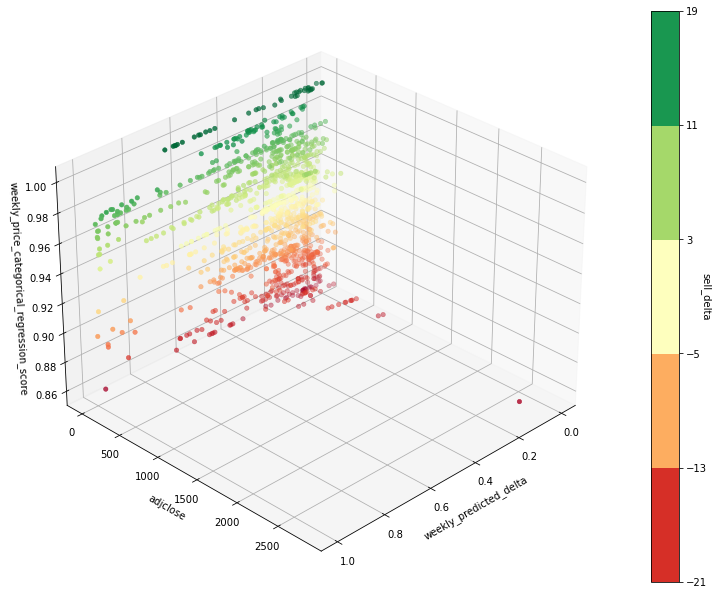

In [298]:
suffix = "heh"
x_axis = "weekly_predicted_delta"
y_axis = "adjclose".format(suffix)
z_axis = "weekly_price_categorical_regression_score".format(suffix)
color = "sell_delta"
z = [[0,0],[0,0]]
buckets = 5
steps = int((int(trades[color].max()*100) - int(trades[color].min()*100)) / buckets)
levels = range(int(trades[color].min()*100),int(trades[color].max()*100),steps)
CS3 = plt.contourf(z,levels,cmap=plt.get_cmap('RdYlGn'))
plt.clf()
fig = plt.figure()
ax = plt.axes(projection='3d')
fig.set_size_inches(18.5, 10.5,10.5)
ax.scatter(trades[x_axis],trades[y_axis],trades[z_axis],c=trades[z_axis], cmap='RdYlGn',linewidth=0.5)
cbar = plt.colorbar(CS3)
cbar.set_label(color, rotation=270)
ax.view_init(30, 45)
ax.set_zlabel(z_axis)
ax.set_ylabel(y_axis)
ax.set_xlabel(x_axis)
plt.show()

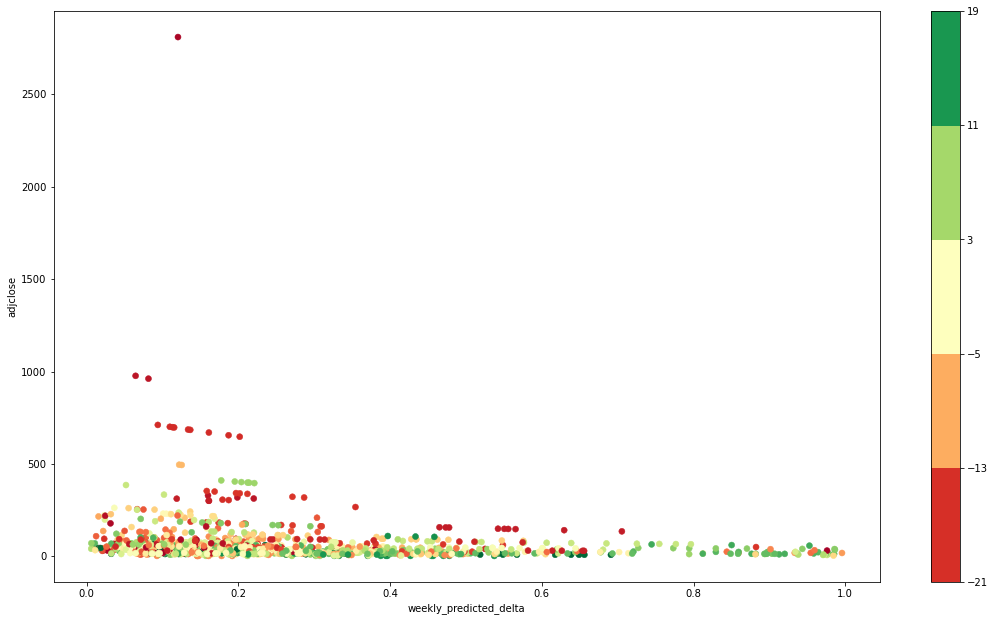

In [299]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
z = [[0,0],[0,0]]
buckets = 5
steps = int((int(trades[color].max()*100) - int(trades[color].min()*100)) / buckets)
levels = range(int(trades[color].min()*100),int(trades[color].max()*100),steps)
CS3 = plt.contourf(z,levels,cmap=plt.get_cmap('RdYlGn'))
plt.clf()
plt.colorbar(CS3)
plt.scatter(trades[x_axis],trades[y_axis],c=trades[z_axis], cmap='RdYlGn',linewidth=0.5)
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.show()

In [300]:
initial = 50
for sd in trades[trades["seat"]==0]["sell_delta"]:
    prev = initial
    initial = initial * (1+sd)
    print(prev,initial,1+sd)

50 54.0 1.08
54.0 56.160000000000004 1.04
56.160000000000004 58.406400000000005 1.04
58.406400000000005 59.57452800000001 1.02
59.57452800000001 60.17027328000001 1.01
60.17027328000001 60.77197601280001 1.01
60.77197601280001 57.12565745203201 0.94
57.12565745203201 55.98314430299137 0.98
55.98314430299137 59.342132961170854 1.06
59.342132961170854 59.93555429078256 1.01
59.93555429078256 58.73684320496691 0.98
58.73684320496691 59.32421163701658 1.01
59.32421163701658 56.951243171535914 0.96
56.951243171535914 54.673193444674475 0.96
54.673193444674475 56.31338924801471 1.03
56.31338924801471 60.25532649537574 1.07
60.25532649537574 72.30639179445089 1.2
72.30639179445089 74.47558354828442 1.03
74.47558354828442 75.9650952192501 1.02
75.9650952192501 75.2054442670576 0.99
75.2054442670576 75.95749870972817 1.01
75.95749870972817 76.71707369682545 1.01
76.71707369682545 75.9499029598572 0.99
75.9499029598572 74.43090490066005 0.98
74.43090490066005 76.66383204767986 1.03
76.6638320476

In [301]:
trades["hpr"].mean()

2.857142857142857